Notebook to analyse the results of pth files

In [1]:
import torch
import init_paths
import os
import cv2

import matplotlib.pyplot as plt
import numpy as np
from src.model.renderer import FootRenderer

In [2]:
gpu = 2
if torch.cuda.is_available():
    torch.cuda.set_device(gpu)
    device = f"cuda:{gpu}"
else:
    device = "cpu"

/home/binders/anaconda3/envs/find_env/lib/python3.10/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU3 GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [6]:
# importation of pth file
os.chdir("/home/binders/FIND")
data = torch.load("exp/latent_optimization/history/0003-A.pth")

In [7]:
data[0].keys()

dict_keys(['step', 'shapevec', 'posevec', 'texvec', 'camera_rotation', 'camera_translation', 'mesh', 'segm_image', 'loss', 'gt_segm_image', 'gt_mesh', 'chamfer_distance'])

In [19]:
# Find the keys from the first dictionary
keys = data[0].keys()

# Now create a dictionary of lists using a dictionary comprehension
dict_of_lists = {key: [d[key] for d in data] for key in keys}

# If you want separate lists, you can do the following
shape_vectors = dict_of_lists["shapevec"]
pose_vectors = dict_of_lists["posevec"]
tex_vectors = dict_of_lists["texvec"]
meshes = dict_of_lists["mesh"]
segmented_images = dict_of_lists["segm_image"]
mse_losses = dict_of_lists["loss"]
chamfer_losses = dict_of_lists["chamfer_distance"]
gt_images = dict_of_lists["gt_segm_image"][0].detach().cpu().numpy()

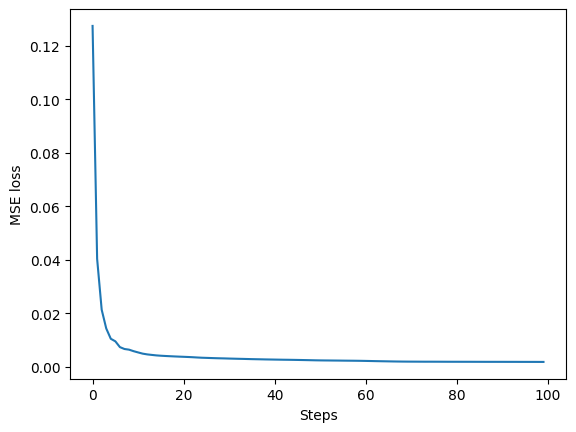

In [9]:
# plot MSE loss
plt.plot(np.arange(len(mse_losses)), mse_losses)
plt.xlabel("Steps")
plt.ylabel("MSE loss")
plt.show()

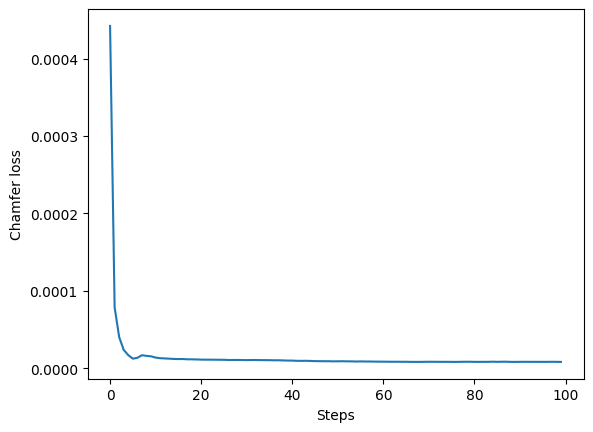

In [10]:
# plot chamfer loss
plt.plot(np.arange(len(chamfer_losses)), chamfer_losses)
plt.xlabel("Steps")
plt.ylabel("Chamfer loss")
plt.show()

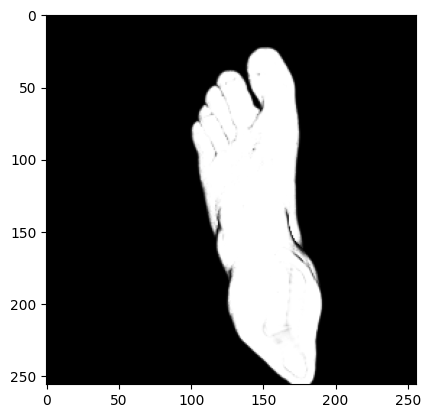

In [11]:
plt.imshow(segmented_images[0][0,0], cmap="gray")
plt.show()

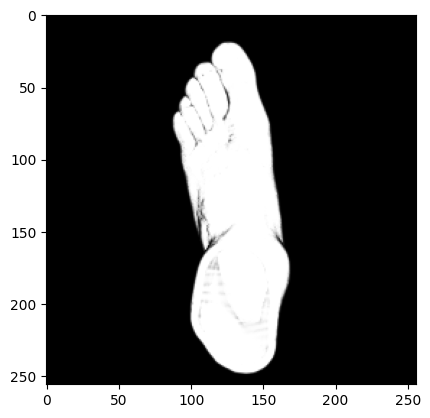

In [12]:
plt.imshow(segmented_images[99][0,0], cmap="gray")
plt.show()

In [13]:
def overlay_images(gt_img, pred_img):
    """
    Overlay the ground truth and prediction images.

    :param gt_img: The ground truth image.
    :param pred_img: The prediction image.
    """
    # ensure the images are grayscale
    if len(gt_img.shape) > 2:
        gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2GRAY)
    if len(pred_img.shape) > 2:
        pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2GRAY)

    # create an empty image for the overlay
    overlay_img = np.zeros((gt_img.shape[0], gt_img.shape[1], 3), dtype=np.uint8)

    # set the ground truth pixels to green
    overlay_img[gt_img > 0] = [0, 255, 0]

    # set the prediction pixels to red
    overlay_img[pred_img > 0] = [0, 0, 255]

    # set the overlapping pixels to white
    overlay_img[(gt_img > 0) & (pred_img > 0)] = [255, 255, 255]

    # create the legend
    cv2.putText(
        overlay_img, "GT", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
    )
    cv2.putText(
        overlay_img, "Pred", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2
    )

    return overlay_img

In [28]:
def add_image_title(image, title, padding=20, text_height=50):
    """
    Add a title to an image by placing it on top of a white background.

    :param image: The image to add the title to.
    :param title: The title to add to the image.
    :param padding: The padding between the image and the background.
    """

    # Get the dimensions of the image
    height, width, _ = image.shape

    # Calculate the dimensions for the background based on the image and padding
    background_height = height + 2 * padding + text_height
    background_width = max(width, text_height) + 2 * padding

    # Create a white background with the calculated dimensions
    background = np.ones((background_height, background_width, 3), dtype=np.uint8) * 255

    # Calculate the coordinates to place the image within the background
    x = (background_width - width) // 2
    y = padding

    # Place the image on the background
    background[y : y + height, x : x + width] = image if image.dtype == np.uint8 else image * 255

    # Add black text on top of the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.6
    text_thickness = 1
    text_size = cv2.getTextSize(title, font, font_scale, text_thickness)[0]
    text_x = (background_width - text_size[0]) // 2
    text_y = y + height + padding + text_size[1] + 5
    text_origin = (text_x, text_y)
    text_color = (0, 0, 0)  # Black color

    cv2.putText(
        background,
        title,
        text_origin,
        font,
        font_scale,
        text_color,
        text_thickness,
        cv2.LINE_AA,
    )

    return background


In [20]:
gt_images

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)

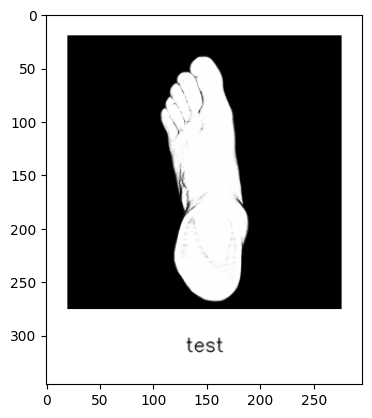

In [31]:
res = add_image_title(cv2.cvtColor(gt_images[0,0], cv2.COLOR_GRAY2BGR), "test")
plt.imshow(res)
plt.show()

In [20]:
# mesh analyse
imsize = 256
renderer = FootRenderer(image_size=imsize, device=device)
# Render feet to images
R, T = renderer.view_from("side2")
out = renderer(
    meshes[99].to(device), 
    R, 
    T, 
    return_mask=True,
    return_images=True,
)  # create the render with the giver camera
image = out['image'][0,0].cpu().numpy()

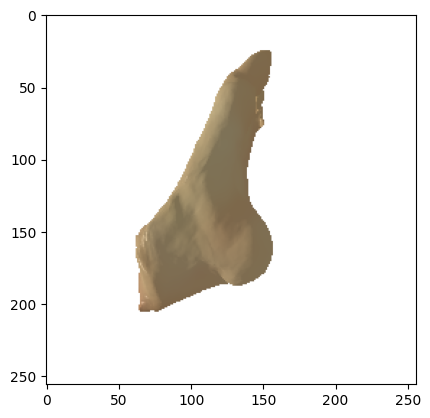

In [21]:
plt.imshow(image)
plt.show()

In [10]:
grid_rows = 25
grid_cols = 4

# Create a new figure and specify the grid layout
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(10*grid_cols, 10*grid_rows))

# Iterate over the image paths and plot each image
for i, ax in enumerate(axes.flatten()):
    # Check if there are more images than subplots
    if i < len(segmented_images):
        # Load the image (assuming you have a function to load images)
        image = segmented_images[i][0,0]

        # Plot the image on the current subplot
        ax.imshow(image, cmap="gray")
        ax.axis("off")
    else:
        # If there are more subplots than images, hide the extra subplots
        ax.axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()